# Imports

In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# Data

In [2]:
root_dir = "../../output/"
os.listdir(root_dir)

['pgg_output_conversation_level.csv',
 'jury_TINY_output_chat_level.csv',
 'jury_output_conversation_level.csv',
 '.DS_Store',
 'pgg_output_chat_level.csv',
 'csop_output_chat_level.csv',
 'beckerestimation_output_chat_level.csv',
 'gurcay2015estimation_output_chat_level.csv',
 'jury_TINY_output_conversation_level.csv',
 'gurcay2015estimation_output_conversation_level.csv',
 'csop_output_conversation_level.csv',
 'beckerestimation_output_conversation_level.csv',
 'jury_output_chat_level.csv']

In [3]:
jury_chat = pd.read_csv(root_dir+"jury_output_chat_level.csv")
jury_conv = pd.read_csv(root_dir+"jury_output_conversation_level.csv")

In [6]:
columns_to_ignore = [
    'conversation_num', 'batch_num', 'round_num', 
    'speaker_hash', 'timestamp', 'majority_pct', 
    'num_flipped', 'flipped_pct', 'num_votes'
]

# Dimensionality Reduction

## PCA

In [9]:
pca = PCA(random_state=42)
pca.fit(jury_conv.drop(columns_to_ignore, axis=1))

PCA(random_state=42)

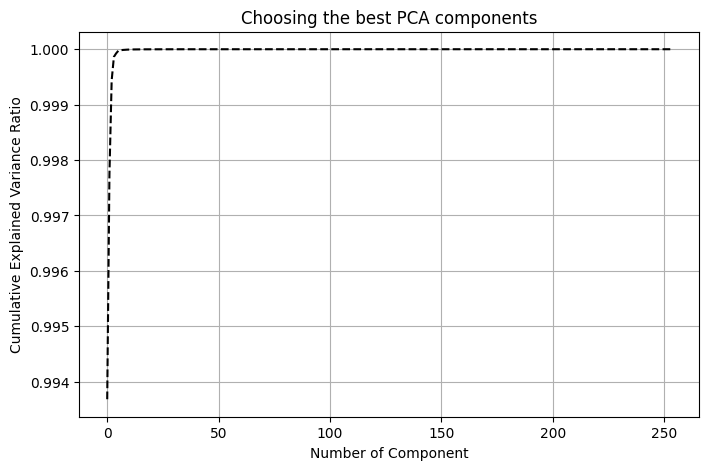

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.cumsum(pca.explained_variance_ratio_), linestyle="--", color="k")
ax.set(xlabel="Number of Components", ylabel="Cumulative Explained Variance Ratio", title="Choosing the best PCA components")
ax.grid()
plt.show()

## t-SNE

In [19]:
tsne = TSNE(random_state=42, n_components=2, perplexity=30)
tsne.fit(jury_conv.drop(columns_to_ignore, axis=1))

TSNE(perplexity=30, random_state=42)

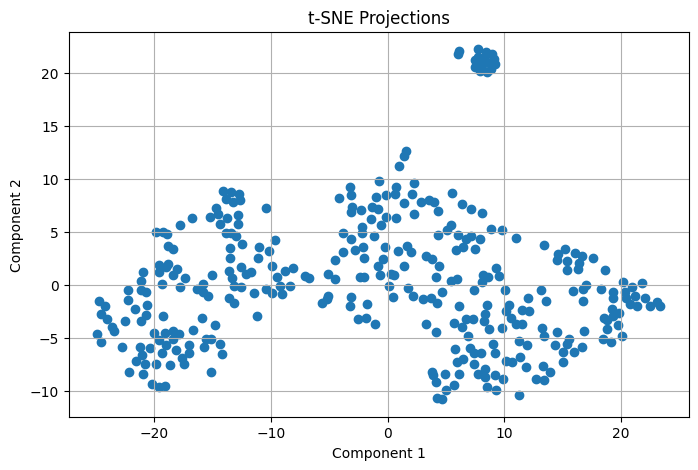

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1])
ax.set(xlabel="Component 1", ylabel="Component 2", title="t-SNE Projections")
ax.grid()
plt.show()

# Clustering

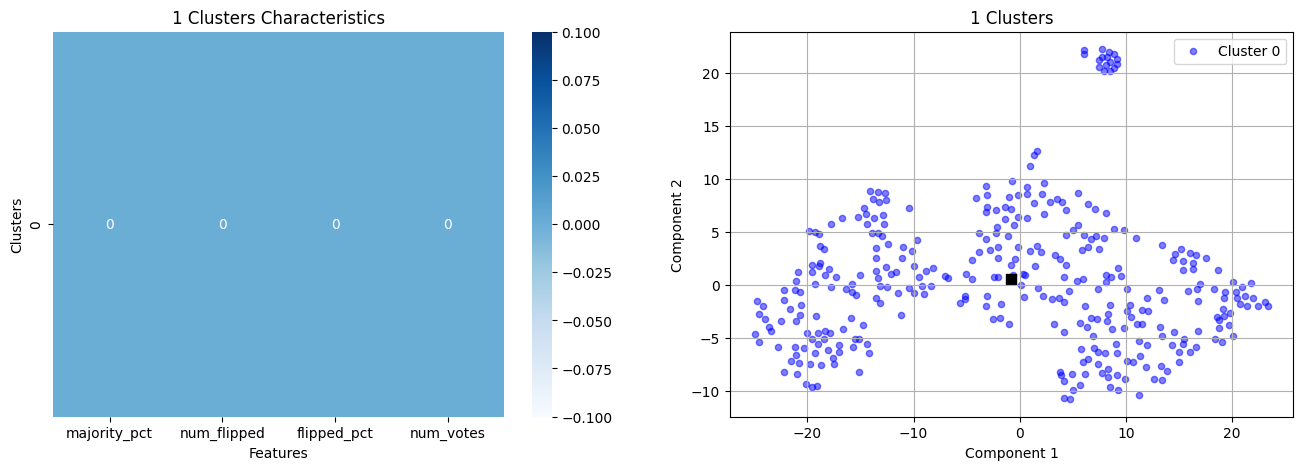

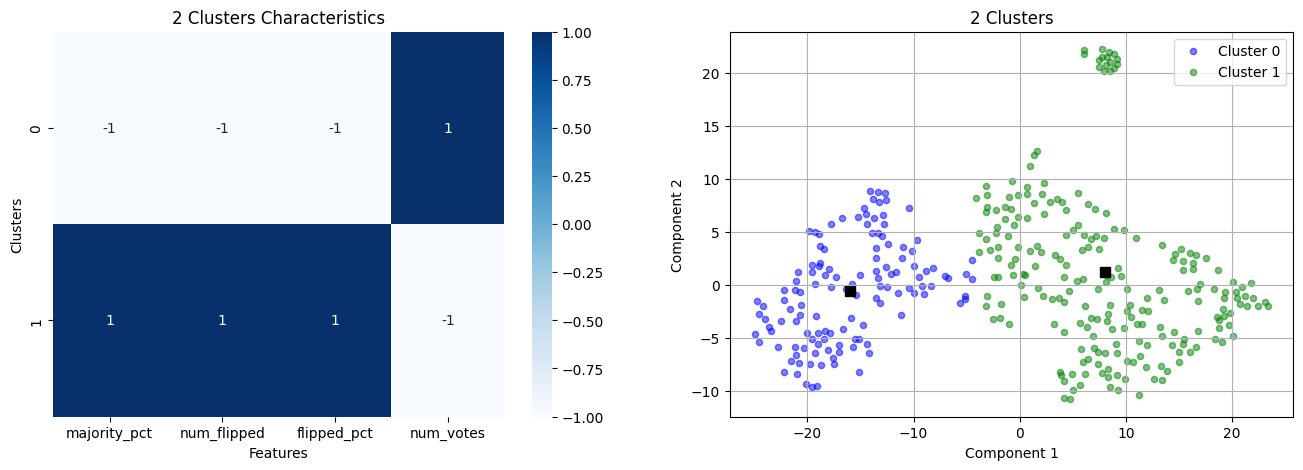

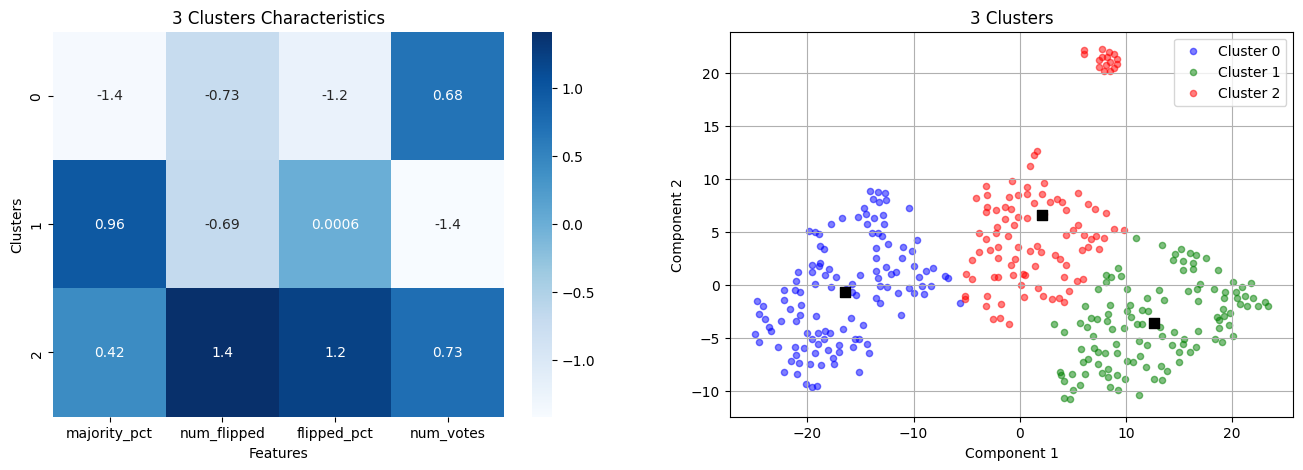

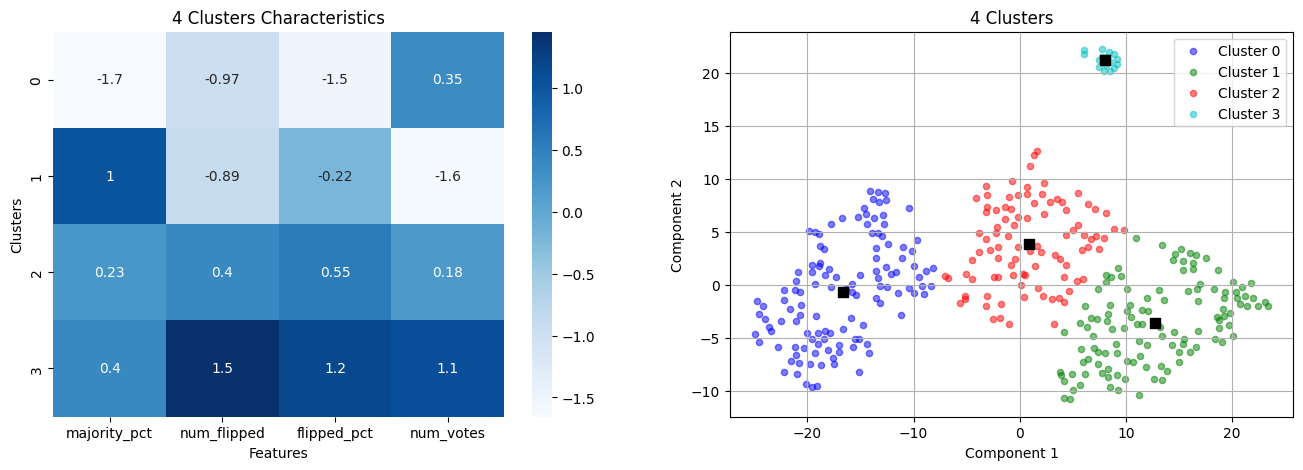

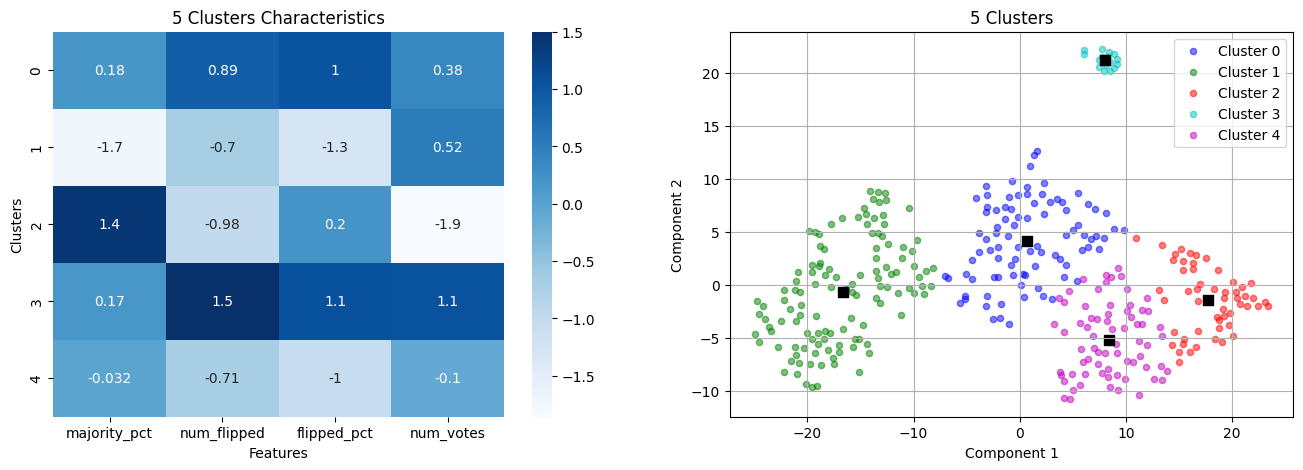

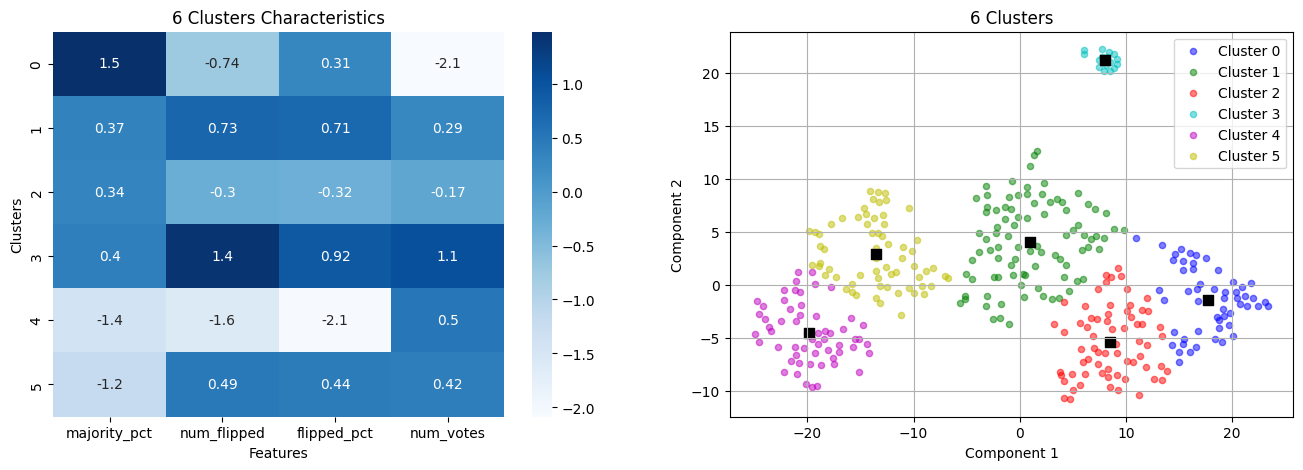

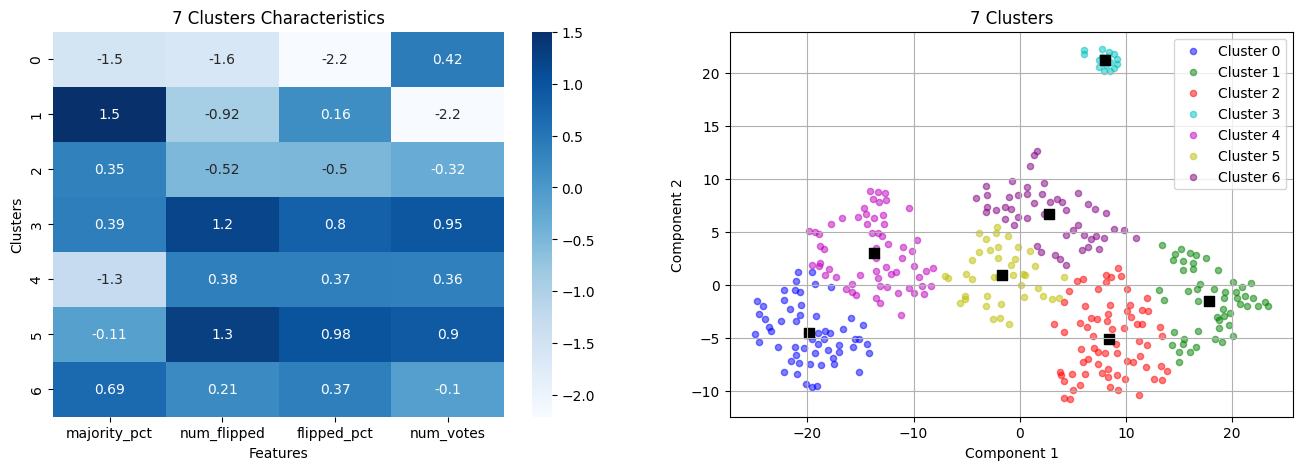

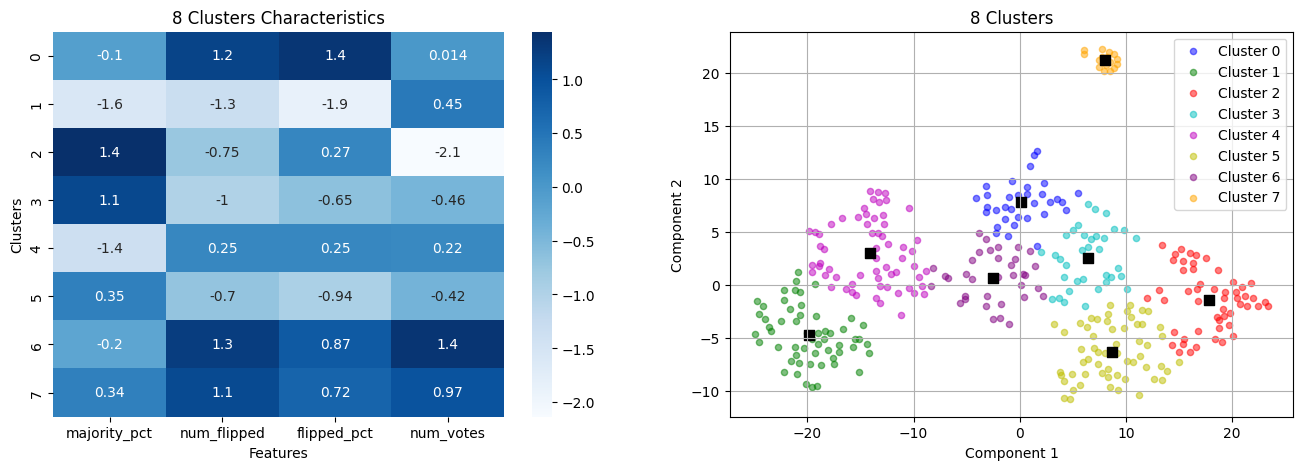

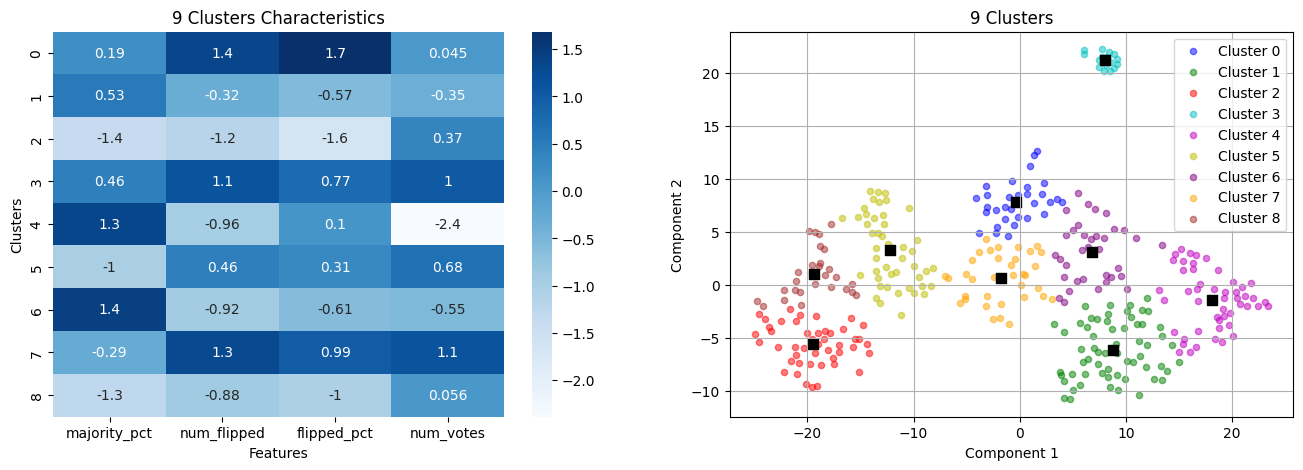

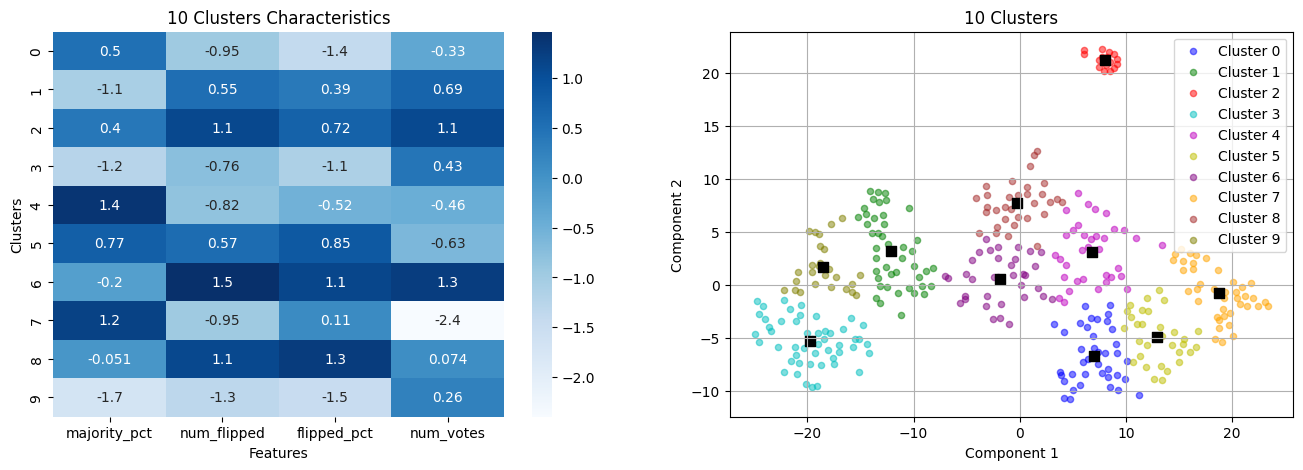

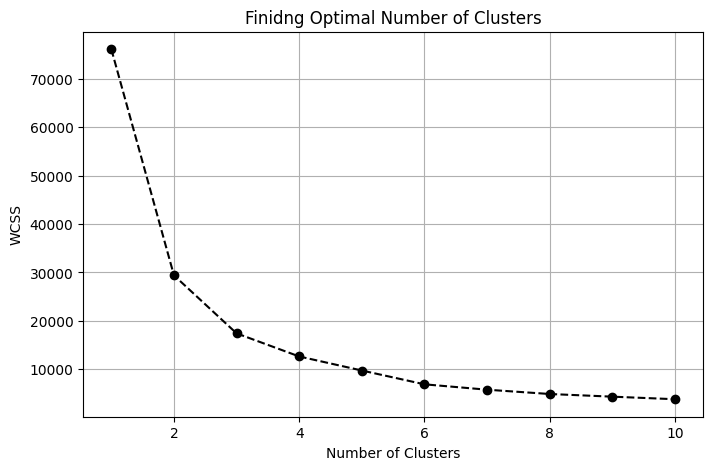

In [74]:
inertias = []
for k in range(1, 11):
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tsne.embedding_)
    inertias.append(kmeans.inertia_)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    # Plot 1 - Cluster Summary
    scaler = StandardScaler()
    summary_df = jury_conv.copy()
    summary_df["Cluster"] = kmeans.labels_
    cluster_summary_df = pd.DataFrame(
        scaler.fit_transform(
            summary_df.groupby(by=["Cluster"])[['majority_pct', 'num_flipped', 'flipped_pct', 'num_votes']].mean()
        ),
        columns = ['majority_pct', 'num_flipped', 'flipped_pct', 'num_votes']
    )
    sns.heatmap(cluster_summary_df, annot=True, cmap="Blues", ax=ax[0])
    ax[0].set(xlabel="Features", ylabel="Clusters", title=f"{k} Clusters Characteristics")
    
    # Plot 2 - Cluster Distribution
    cluster_df = pd.DataFrame({"C1": tsne.embedding_[:, 0], "C2": tsne.embedding_[:, 1], "Cluster": kmeans.labels_})
    colors = ["b", "g", "r", "c", "m", "y", "purple", "orange", "brown", "olive"]
    for cluster in range(0, k):
        cluster_df[cluster_df["Cluster"]==cluster].plot.scatter(
            x="C1", y="C2", ax=ax[1], label=f"Cluster {cluster}", color=colors[cluster], alpha=0.5
        )
    ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="k", marker="s", s=50)
    ax[1].set(xlabel="Component 1", ylabel="Component 2", title=f"{k} Clusters")
    ax[1].grid()
    
    plt.show()

# Elbow Plot for Optimal Number of KMeans Clusters
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1, 11)), inertias, marker="o", linestyle="--", color="k")
ax.set(xlabel="Number of Clusters", ylabel="WCSS", title="Finidng Optimal Number of Clusters")
ax.grid()
plt.show()